In [1]:
import seaborn as sns 
import scanpy as sc
import pandas as pd
import anndata
import numpy as np   
# import episcanpy.api as epi
# import scvi
import matplotlib.pyplot as plt
import scipy
import h5py    
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats

In [2]:
# import muon as mu

# # Import a module with ATAC-seq-related functions
# from muon import atac as ac

EQTL: https://www.nature.com/articles/nature24277#Sec9
pchi-c: https://www.sciencedirect.com/science/article/pii/S0092867416313228?via%3Dihub
data source: https://openproblems.bio/neurips_docs/data/dataset/

In [3]:
from infer_nonsta_dir import infer_nonsta_dir

In [4]:
adata_multi = sc.read_h5ad("./openproblem/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

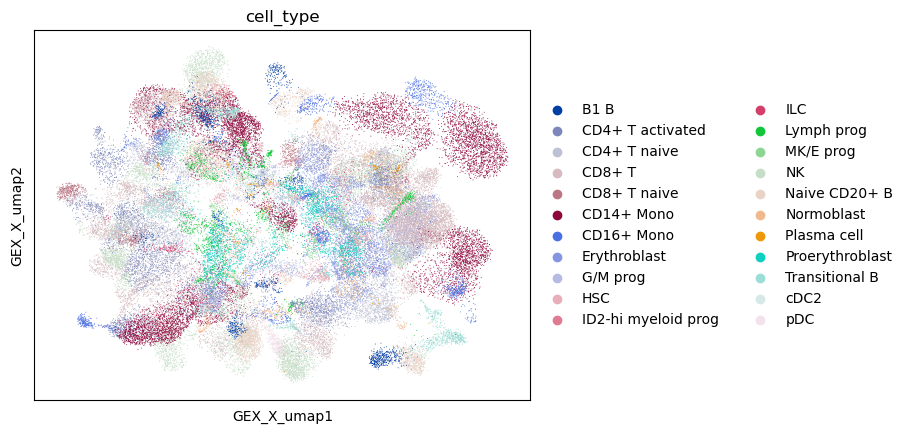

In [5]:
sc.pl.embedding(adata_multi, color=["cell_type"],basis="GEX_X_umap")

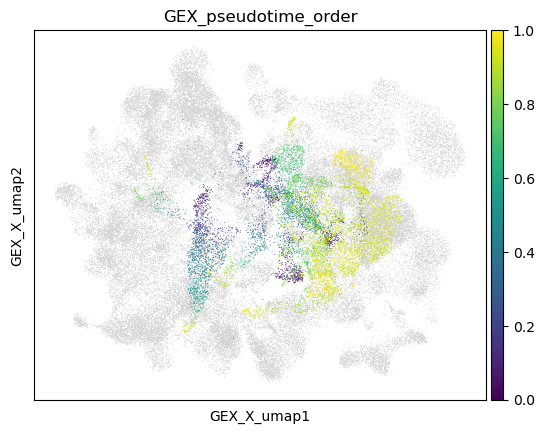

In [6]:
sc.pl.embedding(adata_multi, color=["GEX_pseudotime_order"],basis="GEX_X_umap")

In [7]:
unique, counts = np.unique(adata_multi.obs[~np.isnan(adata_multi.obs['GEX_pseudotime_order'])]['cell_type'], return_counts=True)
dict(zip(unique, counts))

{'Erythroblast': 4916,
 'HSC': 1072,
 'MK/E prog': 884,
 'Normoblast': 1690,
 'Proerythroblast': 2300}

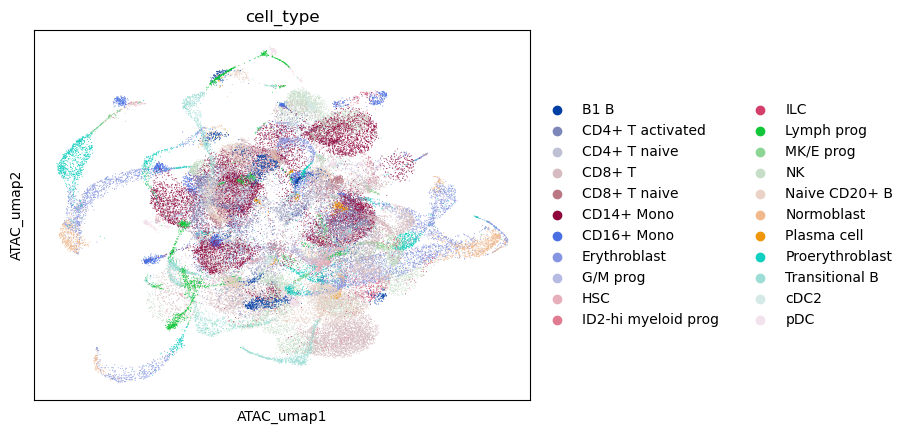

In [8]:
sc.pl.embedding(adata_multi, color=["cell_type"],basis="ATAC_umap")

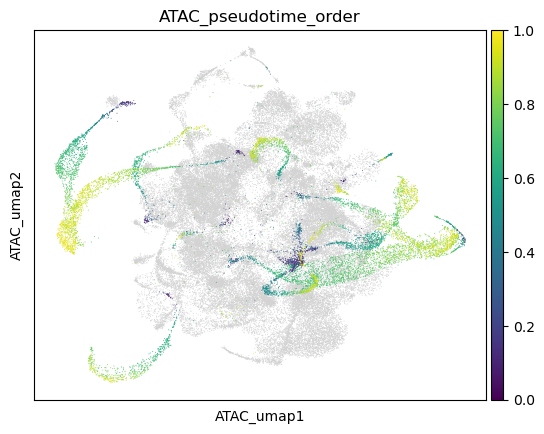

In [9]:
sc.pl.embedding(adata_multi, color=['ATAC_pseudotime_order'],basis="ATAC_umap")

In [10]:
adata_multi_RNA = adata_multi[:, adata_multi.var['feature_types'] == 'GEX'].copy()
adata_multi_ATAC =  adata_multi[:, adata_multi.var['feature_types'] == 'ATAC'].copy()

In [11]:
adata_multi_ATAC

AnnData object with n_obs × n_vars = 69249 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [12]:
adata_multi_ATAC.X

<69249x116490 sparse matrix of type '<class 'numpy.float32'>'
	with 248342179 stored elements in Compressed Sparse Row format>

In [13]:
adata_multi_ATAC.X = adata_multi_ATAC.layers["counts"] 

In [14]:
adata_multi_ATAC

AnnData object with n_obs × n_vars = 69249 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [15]:
adata_multi_ATAC = adata_multi_ATAC[adata_multi.obs_names,:]

In [16]:
all(adata_multi.obs_names == adata_multi_ATAC.obs_names)

True

# test 

In [20]:
adata_atac = adata_multi_ATAC.copy()
scale_factor=1e4
log_tf=False
log_idf=False
log_tfidf=True

In [21]:
npeaks = adata_atac.X.sum(1)
npeaks_inv = csr_matrix(1.0/npeaks)

tf = adata_atac.X.multiply(npeaks_inv)
tf = tf * scale_factor

if log_tf:
    tf = np.log1p(tf)

idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0)),dtype="float32")

if log_idf:
    idf = np.log1p(idf)

tf_idf = np.dot(tf, idf)

if log_tfidf:
    tf_idf = np.log1p(tf_idf)
    

In [22]:
norm_mat = np.nan_to_num(tf_idf, 0) 

In [23]:
norm_mat

<69249x116490 sparse matrix of type '<class 'numpy.float32'>'
	with 248342179 stored elements in Compressed Sparse Row format>

In [24]:
adata_atac.X = norm_mat

In [26]:
print(adata_atac.X[1:10])

  (0, 5)	1.9919671
  (0, 6)	1.418001
  (0, 10)	2.641486
  (0, 41)	2.3700008
  (0, 52)	1.4559692
  (0, 53)	2.3442454
  (0, 117)	1.358227
  (0, 133)	1.7377872
  (0, 144)	2.5289333
  (0, 166)	1.5625572
  (0, 167)	1.386952
  (0, 187)	1.6359543
  (0, 198)	1.7761481
  (0, 203)	1.3923042
  (0, 206)	3.5071929
  (0, 207)	2.537625
  (0, 224)	2.0015142
  (0, 226)	1.5574397
  (0, 242)	1.8626406
  (0, 250)	2.1455114
  (0, 293)	3.1959033
  (0, 359)	1.5262119
  (0, 361)	5.721091
  (0, 366)	4.8369803
  (0, 403)	1.6097015
  :	:
  (8, 115383)	6.1416373
  (8, 115406)	4.27137
  (8, 115428)	2.5065587
  (8, 115464)	2.6436024
  (8, 115477)	2.8519647
  (8, 115480)	2.0260484
  (8, 115599)	2.3870447
  (8, 115608)	5.424255
  (8, 115697)	2.295255
  (8, 115747)	3.700914
  (8, 115789)	3.7555366
  (8, 115932)	3.0263836
  (8, 115958)	3.4051464
  (8, 115968)	3.3174932
  (8, 116108)	2.604741
  (8, 116260)	2.540955
  (8, 116344)	4.486628
  (8, 116352)	4.4191093
  (8, 116377)	2.4019217
  (8, 116407)	1.3020782
  (8, 11642

In [53]:
# def tfidf_norm(adata_atac, scale_factor=1e4, copy=False):
#     """TF-IDF normalization.

#     This function normalizes counts in an AnnData object with TF-IDF.

#     Parameters
#     ----------
#     adata_atac: :class:`~anndata.AnnData`
#         ATAC anndata object.
#     scale_factor: `float` (default: 1e4)
#         Value to be multiplied after normalization.
#     copy: `bool` (default: `False`)
#         Whether to return a copy or modify `.X` directly.

#     Returns
#     -------
#     If `copy==True`, a new ATAC anndata object which stores normalized counts in `.X`.
#     """
#     npeaks = adata_atac.X.sum(1)
#     npeaks_inv = csr_matrix(1.0/npeaks)
#     tf = adata_atac.X.multiply(npeaks_inv)
#     idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
#     if copy:
#         adata_atac_copy = adata_atac.copy()
#         adata_atac_copy.X = tf.dot(idf) * scale_factor
#         return adata_atac_copy
#     else:
#         adata_atac.X = tf.dot(idf) * scale_factor


# Normalization 

In [17]:
from scipy.sparse import coo_matrix, csr_matrix, diags


def tfidf_norm(adata_atac, scale_factor=1e4, copy=False, log_tf=True, log_idf=True, log_tfidf=False):
    """TF-IDF normalization.

    This function normalizes counts in an AnnData object with TF-IDF.

    Parameters
    ----------
    adata_atac: :class:`~anndata.AnnData`
        ATAC anndata object.
    scale_factor: `float` (default: 1e4)
        Value to be multiplied after normalization.
    copy: `bool` (default: `False`)
        Whether to return a copy or modify `.X` directly.
    Returns
    -------
    If `copy==True`, a new ATAC anndata object which stores normalized counts in `.X`.
    """
    
    
    if log_tfidf and (log_tf or log_idf):
        raise AttributeError(
            "When returning log(TF*IDF), \
            applying neither log(TF) nor log(IDF) is possible."
        )
        
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = csr_matrix(1.0/npeaks)
    
    tf = adata_atac.X.multiply(npeaks_inv)
    tf = tf * scale_factor
    
    if log_tf:
        tf = np.log1p(tf)
    
    idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0)),dtype="float32") #,dtype="float32"

    if log_idf:
        idf = np.log1p(idf)
        
    
    tf_idf = np.dot(tf, idf)

    if log_tfidf:
        tf_idf = np.log1p(tf_idf)

    
    if copy:
        adata_atac_copy = adata_atac.copy()
        adata_atac_copy.X = np.nan_to_num(tf_idf, 0) 
        return adata_atac_copy
    else:
        adata_atac.X = np.nan_to_num(tf_idf, 0) 



In [18]:
# run TF-IDF using log(TF*IDF)
adata_multi_ATAC = tfidf_norm(adata_multi_ATAC, scale_factor=1e4, copy=True, log_tf=False, log_idf=False, log_tfidf=True)

In [19]:
print(adata_multi_ATAC.X[1:10])

  (0, 5)	1.9919671
  (0, 6)	1.418001
  (0, 10)	2.641486
  (0, 41)	2.3700008
  (0, 52)	1.4559692
  (0, 53)	2.3442454
  (0, 117)	1.358227
  (0, 133)	1.7377872
  (0, 144)	2.5289333
  (0, 166)	1.5625572
  (0, 167)	1.386952
  (0, 187)	1.6359543
  (0, 198)	1.7761481
  (0, 203)	1.3923042
  (0, 206)	3.5071929
  (0, 207)	2.537625
  (0, 224)	2.0015142
  (0, 226)	1.5574397
  (0, 242)	1.8626406
  (0, 250)	2.1455114
  (0, 293)	3.1959033
  (0, 359)	1.5262119
  (0, 361)	5.721091
  (0, 366)	4.8369803
  (0, 403)	1.6097015
  :	:
  (8, 115383)	6.1416373
  (8, 115406)	4.27137
  (8, 115428)	2.5065587
  (8, 115464)	2.6436024
  (8, 115477)	2.8519647
  (8, 115480)	2.0260484
  (8, 115599)	2.3870447
  (8, 115608)	5.424255
  (8, 115697)	2.295255
  (8, 115747)	3.700914
  (8, 115789)	3.7555366
  (8, 115932)	3.0263836
  (8, 115958)	3.4051464
  (8, 115968)	3.3174932
  (8, 116108)	2.604741
  (8, 116260)	2.540955
  (8, 116344)	4.486628
  (8, 116352)	4.4191093
  (8, 116377)	2.4019217
  (8, 116407)	1.3020782
  (8, 11642

In [20]:
adata_multi.X[:, adata_multi.var['feature_types'] == 'ATAC'].shape

(69249, 116490)

In [29]:
adata_multi.var

,feature_types,gene_id
AL627309.5,GEX,ENSG00000241860
LINC01409,GEX,ENSG00000237491
LINC01128,GEX,ENSG00000228794
NOC2L,GEX,ENSG00000188976
KLHL17,GEX,ENSG00000187961
...,...,...
GL000219.1-90062-90937,ATAC,NaN
GL000219.1-99257-100160,ATAC,NaN
KI270726.1-27152-28034,ATAC,NaN
KI270713.1-21434-22336,ATAC,NaN


In [24]:
adata_multi_V2 = anndata.concat([adata_multi_RNA, adata_multi_ATAC], axis=1,merge='same')

In [25]:
adata_multi_V2

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [26]:
adata_multi_V2.var

,feature_types,gene_id
AL627309.5,GEX,ENSG00000241860
LINC01409,GEX,ENSG00000237491
LINC01128,GEX,ENSG00000228794
NOC2L,GEX,ENSG00000188976
KLHL17,GEX,ENSG00000187961
...,...,...
GL000219.1-90062-90937,ATAC,NaN
GL000219.1-99257-100160,ATAC,NaN
KI270726.1-27152-28034,ATAC,NaN
KI270713.1-21434-22336,ATAC,NaN


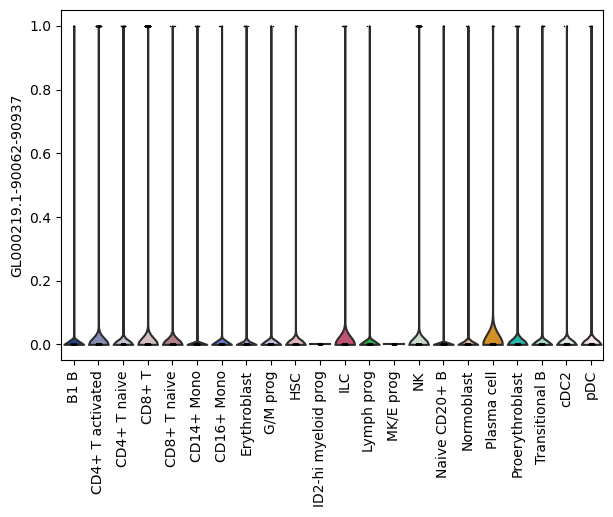

In [45]:
sc.pl.violin(adata_multi, keys=['GL000219.1-90062-90937'], groupby='cell_type',
    rotation=90)

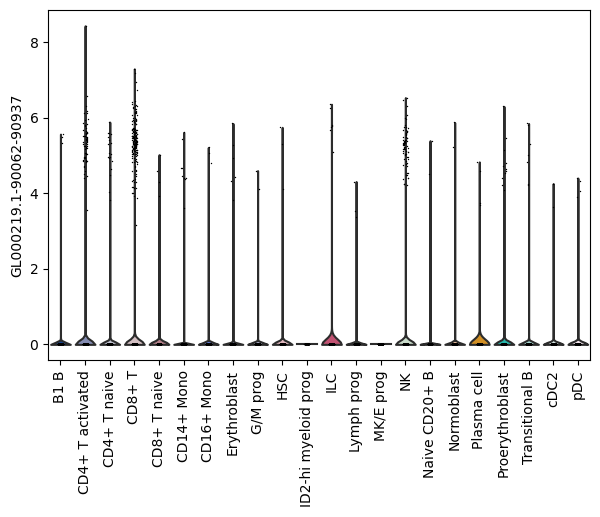

In [46]:
sc.pl.violin(adata_multi_V2, keys=['GL000219.1-90062-90937'], groupby='cell_type',
    rotation=90)

In [37]:
adata_trajectory  = adata_multi[adata_multi.obs['cell_type'].isin(['Erythroblast','HSC','MK/E prog','Normoblast','Proerythroblast'])].copy()
adata_trajectory

AnnData object with n_obs × n_vars = 10952 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

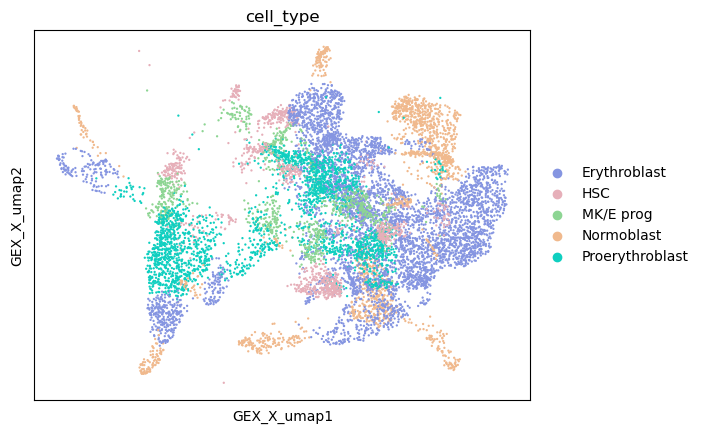

In [38]:
sc.pl.embedding(adata_trajectory, color=["cell_type"],basis="GEX_X_umap")

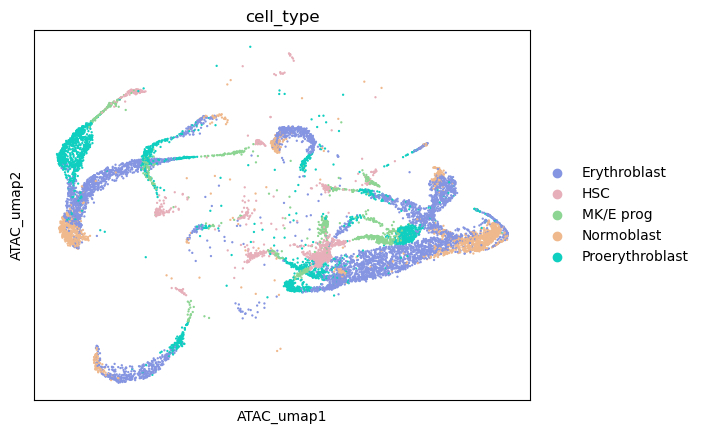

In [39]:
sc.pl.embedding(adata_trajectory, color=["cell_type"],basis="ATAC_umap")

In [40]:
adata_trajectory  = adata_multi_V2[adata_multi_V2.obs['cell_type'].isin(['Erythroblast','HSC','MK/E prog','Normoblast','Proerythroblast'])].copy()
adata_trajectory

AnnData object with n_obs × n_vars = 10952 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

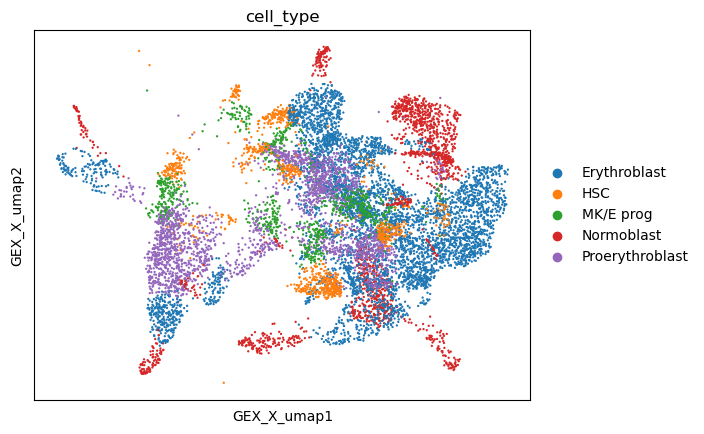

In [41]:
sc.pl.embedding(adata_trajectory, color=["cell_type"],basis="GEX_X_umap")

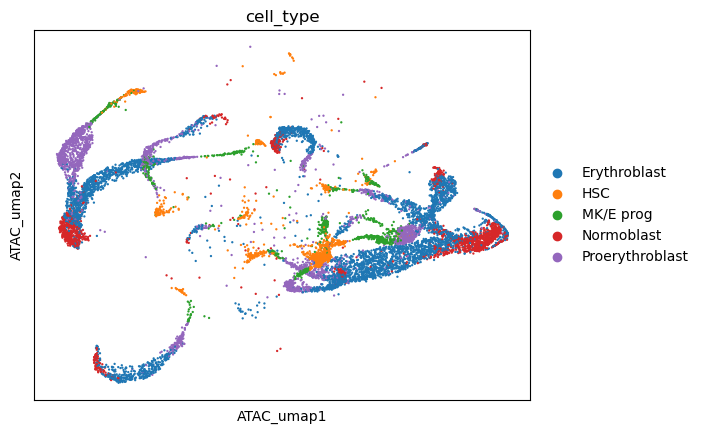

In [42]:
sc.pl.embedding(adata_trajectory, color=["cell_type"],basis="ATAC_umap")

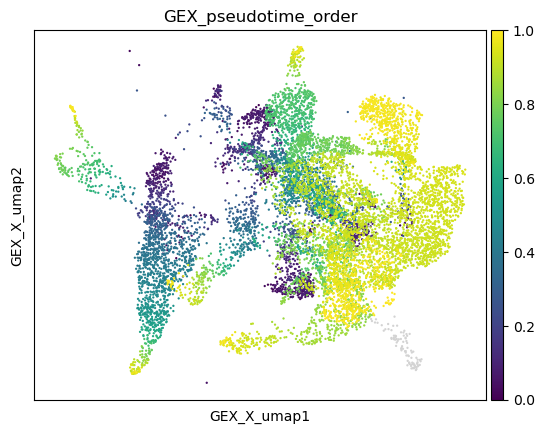

In [31]:
sc.pl.embedding(adata_trajectory, color=["GEX_pseudotime_order"],basis="GEX_X_umap")

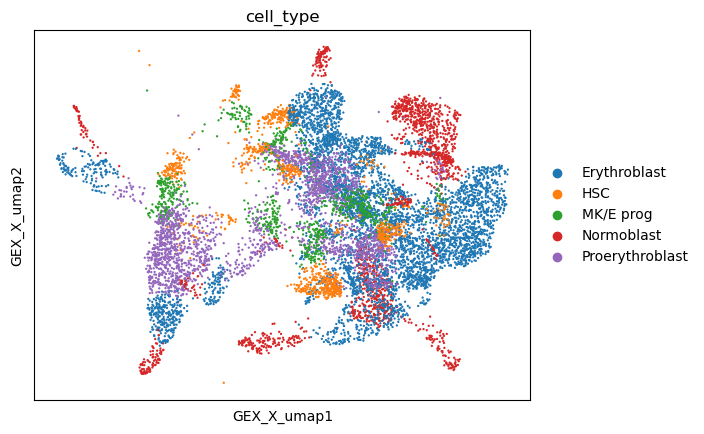

In [47]:
sc.pl.embedding(adata_trajectory, color=["cell_type"],basis="GEX_X_umap")

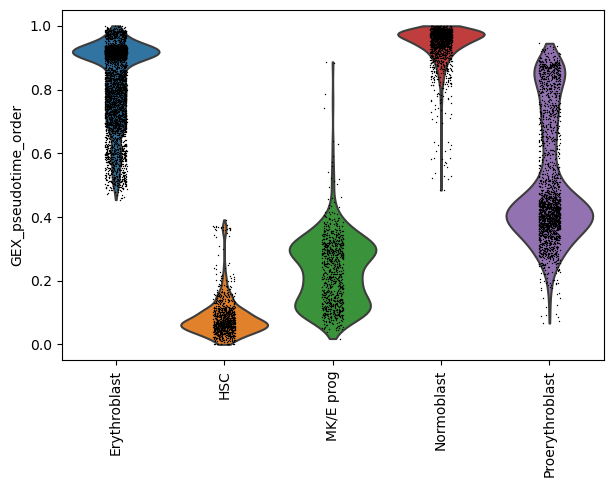

In [48]:
sc.pl.violin(adata_trajectory, keys=['GEX_pseudotime_order'], groupby='cell_type',
    rotation=90)

In [49]:
adata_trajectory

AnnData object with n_obs × n_vars = 10952 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [22]:
unique, counts = np.unique(adata_multi.obs['batch'], return_counts=True)
dict(zip(unique, counts))

{'s1d1': 6224,
 's1d2': 6740,
 's1d3': 4279,
 's2d1': 4220,
 's2d4': 6111,
 's2d5': 4895,
 's3d10': 6781,
 's3d3': 4325,
 's3d6': 1679,
 's3d7': 1771,
 's4d1': 8023,
 's4d8': 9876,
 's4d9': 4325}

In [23]:
unique, counts = np.unique(adata_multi.obs['DonorID'], return_counts=True)
dict(zip(unique, counts))

{10886: 6740,
 11466: 1771,
 12710: 6111,
 13272: 4325,
 15078: 18467,
 16710: 4895,
 18303: 8604,
 19593: 9876,
 28045: 1679,
 28483: 6781}

In [24]:
unique, counts = np.unique(adata_multi.obs['cell_type'], return_counts=True)
dict(zip(unique, counts))

{'B1 B': 1890,
 'CD14+ Mono': 10843,
 'CD16+ Mono': 1894,
 'CD4+ T activated': 5526,
 'CD4+ T naive': 4398,
 'CD8+ T': 11589,
 'CD8+ T naive': 1012,
 'Erythroblast': 4916,
 'G/M prog': 1203,
 'HSC': 1072,
 'ID2-hi myeloid prog': 108,
 'ILC': 835,
 'Lymph prog': 1779,
 'MK/E prog': 884,
 'NK': 6929,
 'Naive CD20+ B': 5052,
 'Normoblast': 1780,
 'Plasma cell': 379,
 'Proerythroblast': 2300,
 'Transitional B': 2810,
 'cDC2': 859,
 'pDC': 1191}

# cd 14 monocyte

In [264]:
CD14_Monocyte  = adata_multi[adata_multi.obs['cell_type']=='CD14+ Mono',].copy()

In [265]:
CD14_Monocyte_RNA = CD14_Monocyte[:,CD14_Monocyte.var['feature_types'] == 'GEX'].copy()
CD14_Monocyte_ATAC = CD14_Monocyte[:,CD14_Monocyte.var['feature_types'] == 'ATAC'].copy()

In [50]:
CD14_Monocyte_RNA.var.index[:40]

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'NOC2L', 'KLHL17', 'ISG15',
       'C1orf159', 'SDF4', 'B3GALT6', 'UBE2J2', 'ACAP3', 'INTS11', 'DVL1',
       'AURKAIP1', 'CCNL2', 'MRPL20', 'ATAD3B', 'ATAD3A', 'SSU72', 'MIB2',
       'MMP23B', 'CDK11B', 'SLC35E2B', 'CDK11A', 'SLC35E2A', 'NADK', 'GNB1',
       'PRKCZ', 'FAAP20', 'SKI', 'MORN1', 'RER1', 'PEX10', 'PLCH2', 'PANK4',
       'AL139246.5', 'TNFRSF14-AS1', 'TNFRSF14', 'PRXL2B', 'TTC34'],
      dtype='object')

In [14]:
cis_reg = pd.read_excel('./openproblem/1246949stables2.xlsx', sheet_name='A. cis.peak.eSNPs.228.paired')  
# cis_reg = cis_reg[cis_reg['Datasets.called']==4]

/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [99]:
shared_RNA,X_index,Y_index = np.intersect1d(cis_reg['Gene'].values.astype(str), CD14_Monocyte_RNA.var_names.to_numpy(), return_indices=True)

In [112]:
shared_RNA[100:200]

array(['ATP9B', 'ATPAF1', 'ATXN3', 'AVL9', 'AVPI1', 'B3GALNT2', 'B4GALT1',
       'BAIAP2', 'BANF1', 'BARD1', 'BAZ2B', 'BBS2', 'BCKDHA', 'BCL10',
       'BCL2L11', 'BCL2L13', 'BCR', 'BET1', 'BEX2', 'BEX4', 'BIN1',
       'BRI3BP', 'BRWD1', 'BSCL2', 'BSG', 'BST1', 'BTN2A1', 'BTN2A2',
       'C3AR1', 'C5', 'CA5B', 'CABLES2', 'CACNA2D4', 'CAMKK2', 'CAMLG',
       'CAMSAP1', 'CANX', 'CAPG', 'CAPZA2', 'CARD16', 'CARD8', 'CARD9',
       'CARHSP1', 'CARS2', 'CASC3', 'CASP7', 'CAST', 'CAT', 'CBL', 'CBLB',
       'CBR4', 'CBX6', 'CC2D1B', 'CCDC115', 'CCDC25', 'CCDC50', 'CCDC58',
       'CCDC66', 'CCDC71', 'CCDC77', 'CCDC90B', 'CCS', 'CCT5', 'CCT8',
       'CD151', 'CD2AP', 'CD300LF', 'CD302', 'CD33', 'CD36', 'CD40',
       'CD47', 'CD55', 'CD99L2', 'CDA', 'CDC16', 'CDC25B', 'CDC42',
       'CDC42BPB', 'CDC42EP3', 'CDC42SE1', 'CDC42SE2', 'CDC7', 'CDK10',
       'CDK2AP1', 'CDK5RAP2', 'CDKN3', 'CDS2', 'CEBPZ', 'CENPN', 'CENPP',
       'CENPQ', 'CEP63', 'CEPT1', 'CERK', 'CFD', 'CFDP1', 'CGGBP1',
 

In [101]:
shared_ATAC,x_index,y_index = np.intersect1d(cis_reg['SNP'].values.astype(str), CD14_Monocyte_ATAC.var_names.to_numpy(), return_indices=True)

In [118]:
CD14_Monocyte_ATAC.var_names.to_numpy()

array(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803', ...,
       'KI270726.1-27152-28034', 'KI270713.1-21434-22336',
       'KI270713.1-29629-30491'], dtype=object)

# Trajectory

In [50]:
adata_trajectory

AnnData object with n_obs × n_vars = 10952 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [51]:
adata_trajectory.var['feature_types']

AL627309.5                  GEX
LINC01409                   GEX
LINC01128                   GEX
NOC2L                       GEX
KLHL17                      GEX
                           ... 
GL000219.1-90062-90937     ATAC
GL000219.1-99257-100160    ATAC
KI270726.1-27152-28034     ATAC
KI270713.1-21434-22336     ATAC
KI270713.1-29629-30491     ATAC
Name: feature_types, Length: 129921, dtype: category
Categories (2, object): ['ATAC', 'GEX']

In [53]:
ATAC_var = adata_trajectory.var_names.to_numpy().astype(str)[adata_trajectory.var['feature_types']=='ATAC']
ATAC_var = [i.split("-") for i in ATAC_var]
ATAC_var = np.array(ATAC_var)
ATAC_var
ATAC_DF = pd.DataFrame({'chr': ATAC_var[:, 0], 'Pos1': ATAC_var[:, 1],'Pos2': ATAC_var[:,2]})
ATAC_DF["Pos1"] = pd.to_numeric(ATAC_DF["Pos1"])
ATAC_DF["Pos2"] = pd.to_numeric(ATAC_DF["Pos2"])

In [54]:
ATAC_DF.loc[(ATAC_DF['chr']=='chr12') & (ATAC_DF['Pos2']<=29675131)  ]

,chr,Pos1,Pos2
22779,chr12,9843,10760
22780,chr12,12504,13430
22781,chr12,21492,22404
22782,chr12,56624,57474
22783,chr12,66631,67591
...,...,...,...
24261,chr12,29385918,29386758
24262,chr12,29390276,29391097
24263,chr12,29427944,29428343
24264,chr12,29428464,29429199


In [55]:
ATAC_DF.loc[(ATAC_DF['chr']=='chr6') & (ATAC_DF['Pos1']>=26196886)  ]

,chr,Pos1,Pos2
93031,chr6,26198962,26199853
93032,chr6,26204229,26205030
93033,chr6,26205163,26205683
93034,chr6,26206019,26206727
93035,chr6,26216392,26217267
...,...,...,...
98626,chr6,170523326,170524198
98627,chr6,170529564,170530454
98628,chr6,170552674,170553380
98629,chr6,170553830,170554736


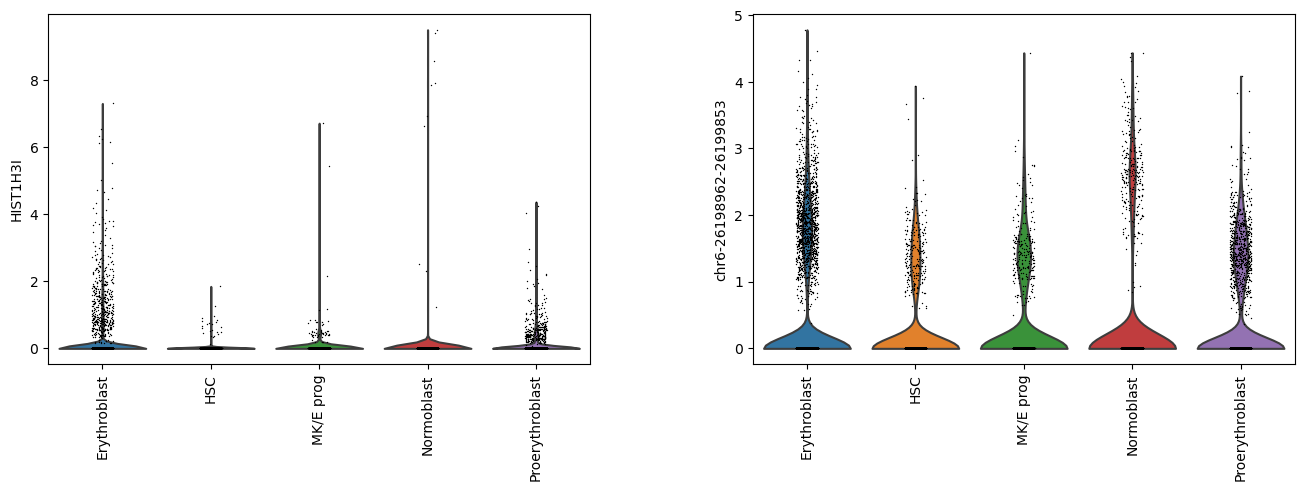

In [91]:
sc.pl.violin(adata_trajectory, keys=['HIST1H3I','chr6-26198962-26199853'], groupby='cell_type',
    rotation=90)

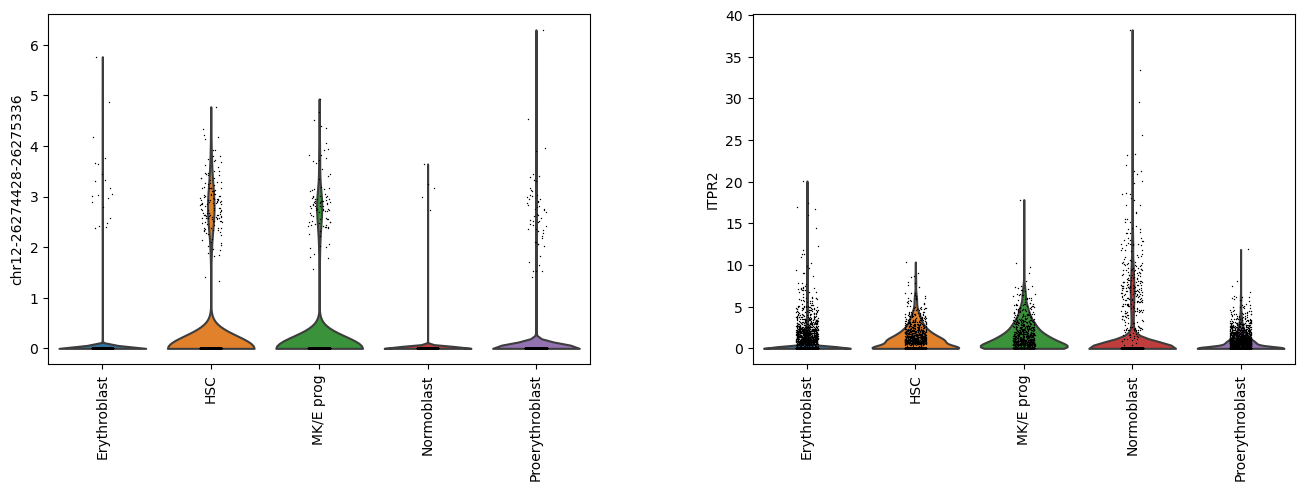

In [92]:
sc.pl.violin(adata_trajectory, keys=['chr12-26274428-26275336','ITPR2'], groupby='cell_type',
    rotation=90)

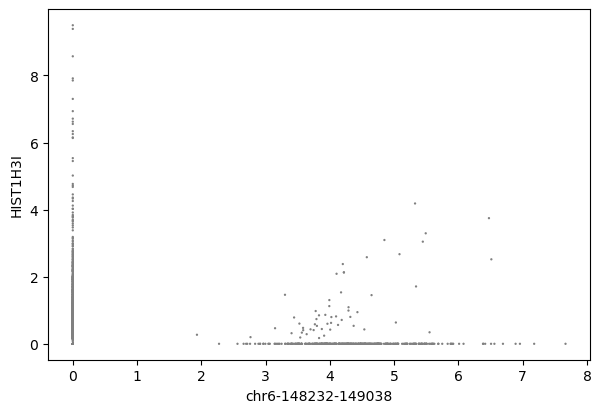

In [59]:
sc.pl.scatter(adata_trajectory,x = 'chr6-148232-149038',y='HIST1H3I')

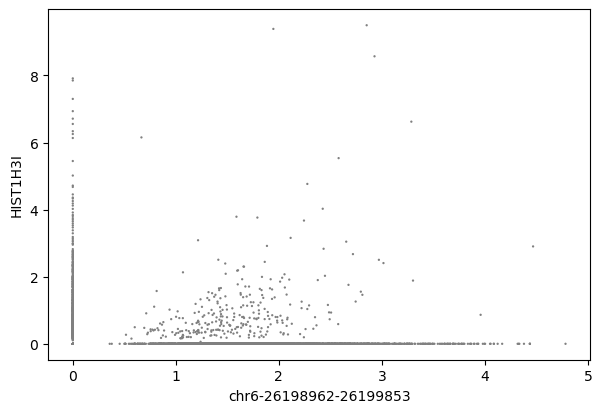

In [60]:
sc.pl.scatter(adata_trajectory,x = 'chr6-26198962-26199853',y='HIST1H3I')

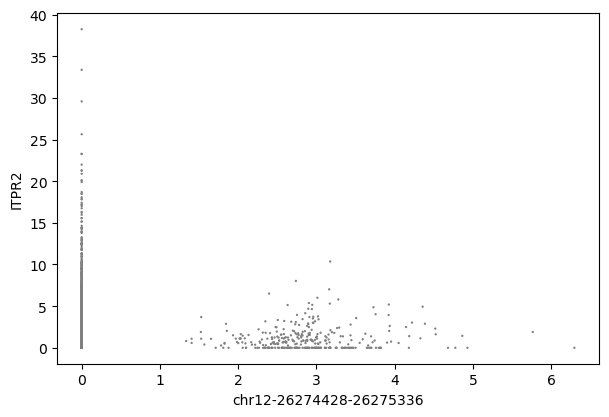

In [82]:
sc.pl.scatter(adata_trajectory,x = 'chr12-26274428-26275336',y='ITPR2')

# test for gene-peak pair without association

In [63]:
data =adata_trajectory.obs['GEX_pseudotime_order'].values
bins = np.linspace(0, 1, 20)
digitized = np.digitize(data, bins)
idx = adata_trajectory.obs['cell_type']=='Erythroblast'

In [66]:
infer_nonsta_dir(X=adata_trajectory[:,'chr6-148232-149038'].to_df().to_numpy(), Y=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)

(0.03825374413811073,
 matrix([[ 0.18139489,  0.18139489,  0.18139489, ..., -0.02317969,
          -0.19894105, -0.01080623],
         [ 0.18139489,  0.18139489,  0.18139489, ..., -0.02317969,
          -0.19894105, -0.01080623],
         [ 0.18139489,  0.18139489,  0.18139489, ..., -0.02317969,
          -0.19894105, -0.01080623],
         ...,
         [-0.02317959, -0.02317959, -0.02317959, ...,  0.4862151 ,
          -0.30128018,  0.38389807],
         [-0.19894097, -0.19894097, -0.19894097, ..., -0.30128017,
           0.79655958, -0.29076163],
         [-0.01080613, -0.01080613, -0.01080613, ...,  0.38389808,
          -0.29076163,  0.48805676]]),
 matrix([[ 0.1567715 ,  0.1567715 ,  0.1567715 , ..., -0.18831143,
          -0.06658804, -0.20316007],
         [ 0.1567715 ,  0.1567715 ,  0.1567715 , ..., -0.18831143,
          -0.06658804, -0.20316007],
         [ 0.1567715 ,  0.1567715 ,  0.1567715 , ..., -0.18831143,
          -0.06658804, -0.20316007],
         ...,
         [-0

In [67]:
infer_nonsta_dir(Y=adata_trajectory[:,'chr6-148232-149038'].to_df().to_numpy(), X=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)

(0.03430522888256698,
 matrix([[ 0.16038935,  0.16038935,  0.16038935, ..., -0.2209133 ,
          -0.04248994, -0.1343994 ],
         [ 0.16038935,  0.16038935,  0.16038935, ..., -0.2209133 ,
          -0.04248994, -0.1343994 ],
         [ 0.16038935,  0.16038935,  0.16038935, ..., -0.2209133 ,
          -0.04248994, -0.1343994 ],
         ...,
         [-0.22091349, -0.22091349, -0.22091349, ...,  0.90093224,
          -0.20911162,  0.40893271],
         [-0.04249015, -0.04249015, -0.04249015, ..., -0.20911161,
           0.59907591, -0.24624667],
         [-0.13439964, -0.13439964, -0.13439964, ...,  0.40893274,
          -0.24624666,  0.61452774]]),
 matrix([[ 0.16551144,  0.16551144,  0.16551144, ...,  0.02263356,
          -0.19835774, -0.03438804],
         [ 0.16551144,  0.16551144,  0.16551144, ...,  0.02263356,
          -0.19835774, -0.03438804],
         [ 0.16551144,  0.16551144,  0.16551144, ...,  0.02263356,
          -0.19835774, -0.03438804],
         ...,
         [ 0

# if delta-X-Y < delta-Y-X : X->Y

In [68]:
infer_nonsta_dir(X=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), Y=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)

(0.02710932146329958,
 matrix([[ 0.15390806,  0.15390806,  0.15390806, ...,  0.01734213,
          -0.11039064, -0.07426131],
         [ 0.15390806,  0.15390806,  0.15390806, ...,  0.01734213,
          -0.11039064, -0.07426131],
         [ 0.15390806,  0.15390806,  0.15390806, ...,  0.01734213,
          -0.11039064, -0.07426131],
         ...,
         [ 0.01734212,  0.01734212,  0.01734212, ...,  0.37862077,
          -0.30421384,  0.3352542 ],
         [-0.11039066, -0.11039066, -0.11039066, ..., -0.30421384,
           0.61968423, -0.27147489],
         [-0.07426132, -0.07426132, -0.07426132, ...,  0.33525421,
          -0.27147489,  0.64936227]]),
 matrix([[ 0.21577823,  0.21577823,  0.21577823, ..., -0.12495588,
          -0.02209519, -0.22360791],
         [ 0.21577823,  0.21577823,  0.21577823, ..., -0.12495588,
          -0.02209519, -0.22360791],
         [ 0.21577823,  0.21577823,  0.21577823, ..., -0.12495588,
          -0.02209519, -0.22360791],
         ...,
         [-0

In [69]:
infer_nonsta_dir(Y=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), X=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)

(0.030606939978545668,
 matrix([[ 0.21910782,  0.21910782,  0.21910782, ..., -0.12553255,
          -0.0243111 , -0.24482827],
         [ 0.21910782,  0.21910782,  0.21910782, ..., -0.12553255,
          -0.0243111 , -0.24482827],
         [ 0.21910782,  0.21910782,  0.21910782, ..., -0.12553255,
          -0.0243111 , -0.24482827],
         ...,
         [-0.12553252, -0.12553252, -0.12553252, ...,  0.41405256,
          -0.16336841,  0.34300351],
         [-0.02431106, -0.02431106, -0.02431106, ..., -0.16336841,
           0.48793841, -0.14388493],
         [-0.24482822, -0.24482822, -0.24482822, ...,  0.3430035 ,
          -0.14388495,  0.61730211]]),
 matrix([[ 0.16551144,  0.16551144,  0.16551144, ...,  0.02263356,
          -0.19835774, -0.03438804],
         [ 0.16551144,  0.16551144,  0.16551144, ...,  0.02263356,
          -0.19835774, -0.03438804],
         [ 0.16551144,  0.16551144,  0.16551144, ...,  0.02263356,
          -0.19835774, -0.03438804],
         ...,
         [ 

In [74]:
infer_nonsta_dir(X=adata_trajectory[:,'chr12-26274428-26275336'].to_df().to_numpy(), Y=adata_trajectory[:,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)

(0.06355566541921095,
 matrix([[ 0.26830422,  0.26830422,  0.26830422, ...,  0.11930868,
          -0.33703017,  0.01508729],
         [ 0.26830422,  0.26830422,  0.26830422, ...,  0.11930868,
          -0.33703017,  0.01508729],
         [ 0.26830422,  0.26830422,  0.26830422, ...,  0.11930868,
          -0.33703017,  0.01508729],
         ...,
         [ 0.11930867,  0.11930867,  0.11930867, ...,  0.18839455,
          -0.34601887,  0.16377256],
         [-0.33703016, -0.33703016, -0.33703016, ..., -0.34601887,
           1.0307177 , -0.29770629],
         [ 0.0150873 ,  0.0150873 ,  0.0150873 , ...,  0.16377255,
          -0.2977063 ,  0.22127855]]),
 matrix([[ 0.17926874,  0.17926874,  0.17926874, ...,  0.13997661,
          -0.22088928,  0.09752773],
         [ 0.17926874,  0.17926874,  0.17926874, ...,  0.13997661,
          -0.22088928,  0.09752773],
         [ 0.17926874,  0.17926874,  0.17926874, ...,  0.13997661,
          -0.22088928,  0.09752773],
         ...,
         [ 0

In [75]:
infer_nonsta_dir(Y=adata_trajectory[:,'chr12-26274428-26275336'].to_df().to_numpy(), X=adata_trajectory[:,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)

(0.047017068679997866,
 matrix([[ 0.20835422,  0.20835422,  0.20835422, ...,  0.02220766,
          -0.18738646,  0.00186925],
         [ 0.20835422,  0.20835422,  0.20835422, ...,  0.02220766,
          -0.18738646,  0.00186925],
         [ 0.20835422,  0.20835422,  0.20835422, ...,  0.02220766,
          -0.18738646,  0.00186925],
         ...,
         [ 0.02220765,  0.02220765,  0.02220765, ...,  0.2533012 ,
          -0.16491275,  0.20064733],
         [-0.18738647, -0.18738647, -0.18738647, ..., -0.16491275,
           1.416872  , -0.13101522],
         [ 0.00186924,  0.00186924,  0.00186924, ...,  0.20064734,
          -0.13101522,  0.3210967 ]]),
 matrix([[ 0.27406227,  0.27406227,  0.27406227, ...,  0.11943171,
          -0.33443556,  0.00861759],
         [ 0.27406227,  0.27406227,  0.27406227, ...,  0.11943171,
          -0.33443556,  0.00861759],
         [ 0.27406227,  0.27406227,  0.27406227, ...,  0.11943171,
          -0.33443556,  0.00861759],
         ...,
         [ 

In [105]:
data =adata_trajectory.obs['ATAC_pseudotime_order'].values
bins = np.linspace(0, 1, 20)
digitized = np.digitize(data, bins)
idx = adata_trajectory.obs['cell_type']=='Erythroblast'

In [106]:
testStat, Mg, Mg2 = infer_nonsta_dir(X=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), Y=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)
print(testStat)

0.029449288380112442


In [107]:
testStat, Mg, Mg2 = infer_nonsta_dir(Y=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), X=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)
print(testStat)

0.029955976197106535


In [108]:
testStat, Mg, Mg2 = infer_nonsta_dir(X=adata_trajectory[:,'chr12-26274428-26275336'].to_df().to_numpy(), Y=adata_trajectory[:,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)
print(testStat)

0.0621455839723143


In [109]:
testStat, Mg, Mg2 = infer_nonsta_dir(Y=adata_trajectory[:,'chr12-26274428-26275336'].to_df().to_numpy(), X=adata_trajectory[:,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.1, IF_GP=False)
print(testStat)

0.04132414334764064


In [70]:
infer_nonsta_dir(X=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), Y=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.5, IF_GP=False)

(0.029204632766239316,
 matrix([[ 0.18762717,  0.18762717,  0.18762717, ...,  0.05064659,
          -0.11326037,  0.01198085],
         [ 0.18762717,  0.18762717,  0.18762717, ...,  0.05064659,
          -0.11326037,  0.01198085],
         [ 0.18762717,  0.18762717,  0.18762717, ...,  0.05064659,
          -0.11326037,  0.01198085],
         ...,
         [ 0.05064657,  0.05064657,  0.05064657, ...,  0.39626728,
          -0.29368839,  0.37812636],
         [-0.11326035, -0.11326035, -0.11326035, ..., -0.29368841,
           0.62810302, -0.26594629],
         [ 0.01198086,  0.01198086,  0.01198086, ...,  0.37812634,
          -0.26594629,  0.61180327]]),
 matrix([[ 0.24090647,  0.24090647,  0.24090647, ..., -0.08655173,
          -0.13313985, -0.21860512],
         [ 0.24090647,  0.24090647,  0.24090647, ..., -0.08655173,
          -0.13313985, -0.21860512],
         [ 0.24090647,  0.24090647,  0.24090647, ..., -0.08655173,
          -0.13313985, -0.21860512],
         ...,
         [-

In [71]:
infer_nonsta_dir(Y=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), X=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.5, IF_GP=False)

(0.03335038122745464,
 matrix([[ 0.24619182,  0.24619182,  0.24619182, ..., -0.08787238,
          -0.13827054, -0.23375336],
         [ 0.24619182,  0.24619182,  0.24619182, ..., -0.08787238,
          -0.13827054, -0.23375336],
         [ 0.24619182,  0.24619182,  0.24619182, ..., -0.08787238,
          -0.13827054, -0.23375336],
         ...,
         [-0.08787236, -0.08787236, -0.08787236, ...,  0.37756356,
          -0.15128143,  0.32584219],
         [-0.13827055, -0.13827055, -0.13827055, ..., -0.15128142,
           0.59785945, -0.08717246],
         [-0.23375334, -0.23375334, -0.23375334, ...,  0.3258422 ,
          -0.08717248,  0.4724184 ]]),
 matrix([[ 0.21216057,  0.21216057,  0.21216057, ...,  0.06883517,
          -0.18694821,  0.03900424],
         [ 0.21216057,  0.21216057,  0.21216057, ...,  0.06883517,
          -0.18694821,  0.03900424],
         [ 0.21216057,  0.21216057,  0.21216057, ...,  0.06883517,
          -0.18694821,  0.03900424],
         ...,
         [ 0

In [72]:
infer_nonsta_dir(X=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), Y=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.05, IF_GP=False)

(0.02717679653864141,
 matrix([[ 0.16758741,  0.16758741,  0.16758741, ...,  0.0058827 ,
          -0.13598702, -0.1015164 ],
         [ 0.16758741,  0.16758741,  0.16758741, ...,  0.0058827 ,
          -0.13598702, -0.1015164 ],
         [ 0.16758741,  0.16758741,  0.16758741, ...,  0.0058827 ,
          -0.13598702, -0.1015164 ],
         ...,
         [ 0.00588271,  0.00588271,  0.00588271, ...,  0.4047751 ,
          -0.32279371,  0.3397174 ],
         [-0.13598704, -0.13598704, -0.13598704, ..., -0.3227937 ,
           0.64008234, -0.26685317],
         [-0.10151643, -0.10151643, -0.10151643, ...,  0.33971742,
          -0.26685317,  0.70026901]]),
 matrix([[ 0.20104666,  0.20104666,  0.20104666, ..., -0.1341863 ,
           0.03541907, -0.21977207],
         [ 0.20104666,  0.20104666,  0.20104666, ..., -0.1341863 ,
           0.03541907, -0.21977207],
         [ 0.20104666,  0.20104666,  0.20104666, ..., -0.1341863 ,
           0.03541907, -0.21977207],
         ...,
         [-0

In [73]:
infer_nonsta_dir(Y=adata_trajectory[:,'chr6-26198962-26199853'].to_df().to_numpy(), X=adata_trajectory[:,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized,axis=1), width=0.05, IF_GP=False)

(0.02900785655348046,
 matrix([[ 0.19895025,  0.19895025,  0.19895025, ..., -0.12935326,
           0.03734008, -0.23984694],
         [ 0.19895025,  0.19895025,  0.19895025, ..., -0.12935326,
           0.03734008, -0.23984694],
         [ 0.19895025,  0.19895025,  0.19895025, ..., -0.12935326,
           0.03734008, -0.23984694],
         ...,
         [-0.12935337, -0.12935337, -0.12935337, ...,  0.39623878,
          -0.17062094,  0.31617177],
         [ 0.03734012,  0.03734012,  0.03734012, ..., -0.17062101,
           0.41130582, -0.17781946],
         [-0.23984699, -0.23984699, -0.23984699, ...,  0.31617173,
          -0.17781942,  0.61662266]]),
 matrix([[ 0.15445127,  0.15445127,  0.15445127, ...,  0.01010216,
          -0.20997686, -0.04684825],
         [ 0.15445127,  0.15445127,  0.15445127, ...,  0.01010216,
          -0.20997686, -0.04684825],
         [ 0.15445127,  0.15445127,  0.15445127, ...,  0.01010216,
          -0.20997686, -0.04684825],
         ...,
         [ 0

In [98]:
data =adata_trajectory.obs['GEX_pseudotime_order'].values
bins = np.linspace(0, 1, 50)
digitized = np.digitize(data, bins)
idx = adata_trajectory.obs['cell_type']=='Erythroblast'

In [99]:
infer_nonsta_dir(X=adata_trajectory[idx,'chr12-26274428-26275336'].to_df().to_numpy(), Y=adata_trajectory[idx,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.0209898850609654,
 matrix([[ 0.30275407,  0.05859846,  0.30275407, ...,  0.05859846,
          -0.30173296, -0.19563979],
         [ 0.05859846,  0.14200824,  0.05859846, ...,  0.14200824,
          -0.13626541, -0.05732719],
         [ 0.30275407,  0.05859846,  0.30275407, ...,  0.05859846,
          -0.30173296, -0.19563979],
         ...,
         [ 0.05859846,  0.14200824,  0.05859846, ...,  0.14200824,
          -0.13626541, -0.05732719],
         [-0.30173296, -0.1362654 , -0.30173296, ..., -0.1362654 ,
           0.71227106,  0.06845696],
         [-0.19563979, -0.05732719, -0.19563979, ..., -0.05732719,
           0.06845696,  0.40476495]]),
 matrix([[ 0.26098866, -0.13347127,  0.26098866, ..., -0.13347127,
          -0.0106823 , -0.0252202 ],
         [-0.13347123,  0.25900791, -0.13347123, ...,  0.25900791,
           0.09566867,  0.11982896],
         [ 0.26098866, -0.13347127,  0.26098866, ..., -0.13347127,
          -0.0106823 , -0.0252202 ],
         ...,
         [-0.

In [100]:
infer_nonsta_dir(Y=adata_trajectory[idx,'chr12-26274428-26275336'].to_df().to_numpy(), X=adata_trajectory[idx,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.0169267963950062,
 matrix([[ 0.18577998,  0.13291405,  0.18577998, ...,  0.13291405,
          -0.07123169, -0.0245072 ],
         [ 0.13291408,  0.23151194,  0.13291408, ...,  0.23151194,
          -0.04761334, -0.03473367],
         [ 0.18577998,  0.13291405,  0.18577998, ...,  0.13291405,
          -0.07123169, -0.0245072 ],
         ...,
         [ 0.13291408,  0.23151194,  0.13291408, ...,  0.23151194,
          -0.04761334, -0.03473367],
         [-0.07123172, -0.04761333, -0.07123172, ..., -0.04761333,
           0.2337624 ,  0.10824952],
         [-0.02450723, -0.03473369, -0.02450723, ..., -0.03473369,
           0.10824954,  0.18327774]]),
 matrix([[ 0.30510315,  0.05931573,  0.30510315, ...,  0.05931573,
          -0.30423259, -0.19702969],
         [ 0.05931573,  0.14685061,  0.05931573, ...,  0.14685061,
          -0.13591571, -0.05376267],
         [ 0.30510315,  0.05931573,  0.30510315, ...,  0.05931573,
          -0.30423259, -0.19702969],
         ...,
         [ 0.

In [101]:
infer_nonsta_dir(X=adata_trajectory[idx,'chr6-26198962-26199853'].to_df().to_numpy(), Y=adata_trajectory[idx,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.009828329378014063,
 matrix([[ 0.12756201,  0.03489021,  0.12756201, ...,  0.03489021,
          -0.02704981, -0.04363006],
         [ 0.03489022,  0.11470936,  0.03489022, ...,  0.11470936,
          -0.02396989, -0.05028361],
         [ 0.12756201,  0.03489021,  0.12756201, ...,  0.03489021,
          -0.02704981, -0.04363006],
         ...,
         [ 0.03489022,  0.11470936,  0.03489022, ...,  0.11470936,
          -0.02396989, -0.05028361],
         [-0.02704982, -0.02396989, -0.02704982, ..., -0.02396989,
           0.36736266,  0.09817442],
         [-0.04363006, -0.05028361, -0.04363006, ..., -0.05028361,
           0.09817442,  0.38614793]]),
 matrix([[ 0.12097873,  0.02663688,  0.12097873, ...,  0.02663688,
           0.00632824, -0.07136741],
         [ 0.02663688,  0.31416956,  0.02663688, ...,  0.31416956,
           0.01282853, -0.25777508],
         [ 0.12097873,  0.02663688,  0.12097873, ...,  0.02663688,
           0.00632824, -0.07136741],
         ...,
         [ 

In [102]:
infer_nonsta_dir(Y=adata_trajectory[idx,'chr6-26198962-26199853'].to_df().to_numpy(), X=adata_trajectory[idx,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.009285361160230605,
 matrix([[ 0.10958084,  0.03660873,  0.10958084, ...,  0.03660873,
          -0.01228477, -0.05048391],
         [ 0.03660876,  0.30124034,  0.03660876, ...,  0.30124034,
          -0.11342263, -0.20790051],
         [ 0.10958084,  0.03660873,  0.10958084, ...,  0.03660873,
          -0.01228477, -0.05048391],
         ...,
         [ 0.03660876,  0.30124034,  0.03660876, ...,  0.30124034,
          -0.11342263, -0.20790051],
         [-0.01228479, -0.11342262, -0.01228479, ..., -0.11342262,
           0.44558313,  0.02984556],
         [-0.05048395, -0.20790052, -0.05048395, ..., -0.20790052,
           0.02984558,  0.41490341]]),
 matrix([[ 0.10412456,  0.0373123 ,  0.10412456, ...,  0.0373123 ,
           0.04790102, -0.14818343],
         [ 0.0373123 ,  0.10572362,  0.0373123 , ...,  0.10572362,
           0.0081978 , -0.10924667],
         [ 0.10412456,  0.0373123 ,  0.10412456, ...,  0.0373123 ,
           0.04790102, -0.14818343],
         ...,
         [ 

In [93]:
data =adata_trajectory.obs['ATAC_pseudotime_order'].values
bins = np.linspace(0, 1, 50)
digitized = np.digitize(data, bins)
idx = adata_trajectory.obs['cell_type']=='Erythroblast'

In [94]:
infer_nonsta_dir(X=adata_trajectory[idx,'chr12-26274428-26275336'].to_df().to_numpy(), Y=adata_trajectory[idx,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.009330311597775798,
 matrix([[ 0.26160504,  0.04490093,  0.04490093, ...,  0.10526776,
           0.08928828,  0.02614718],
         [ 0.04490093,  0.39778987,  0.39778987, ..., -0.14585365,
          -0.15800663,  0.12581893],
         [ 0.04490093,  0.39778987,  0.39778987, ..., -0.14585365,
          -0.15800663,  0.12581893],
         ...,
         [ 0.10526777, -0.14585365, -0.14585365, ...,  0.50869039,
           0.16187005, -0.15070566],
         [ 0.0892883 , -0.15800662, -0.15800662, ...,  0.16187005,
           0.52061018, -0.08721394],
         [ 0.02614719,  0.12581894,  0.12581894, ..., -0.15070566,
          -0.08721393,  0.30887388]]),
 matrix([[ 0.75557213, -0.05183085, -0.05183085, ...,  0.20161444,
          -0.21850829,  0.00952048],
         [-0.05183084,  0.2678895 ,  0.2678895 , ...,  0.04687852,
           0.00698036,  0.01575724],
         [-0.05183084,  0.2678895 ,  0.2678895 , ...,  0.04687852,
           0.00698036,  0.01575724],
         ...,
         [ 

In [95]:
infer_nonsta_dir(Y=adata_trajectory[idx,'chr12-26274428-26275336'].to_df().to_numpy(), X=adata_trajectory[idx,'ITPR2'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.01216427049188599,
 matrix([[ 0.51632199,  0.29021514,  0.29021514, ...,  0.14944291,
          -0.08668481, -0.00624998],
         [ 0.29021514,  0.40010481,  0.40010481, ...,  0.1328169 ,
          -0.06260956, -0.01380179],
         [ 0.29021514,  0.40010481,  0.40010481, ...,  0.1328169 ,
          -0.06260956, -0.01380179],
         ...,
         [ 0.14944291,  0.1328169 ,  0.1328169 , ...,  0.65246768,
          -0.14822116,  0.00335693],
         [-0.0866848 , -0.06260955, -0.06260955, ..., -0.14822115,
           0.1605289 ,  0.00387088],
         [-0.00624999, -0.01380179, -0.01380179, ...,  0.00335692,
           0.00387087,  0.27168061]]),
 matrix([[ 0.24694032,  0.02157887,  0.02157887, ...,  0.11087184,
           0.09449202,  0.01905226],
         [ 0.02157887,  0.38942778,  0.38942778, ..., -0.1439308 ,
          -0.15527541,  0.13261716],
         [ 0.02157887,  0.38942778,  0.38942778, ..., -0.1439308 ,
          -0.15527541,  0.13261716],
         ...,
         [ 0

In [96]:
infer_nonsta_dir(X=adata_trajectory[idx,'chr6-26198962-26199853'].to_df().to_numpy(), Y=adata_trajectory[idx,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.018698467206437117,
 matrix([[ 0.27421173,  0.0606249 ,  0.0606249 , ..., -0.01008515,
           0.02138367,  0.09007625],
         [ 0.0606249 ,  0.69215947,  0.69215947, ...,  0.54764733,
          -0.10224286,  0.00957976],
         [ 0.0606249 ,  0.69215947,  0.69215947, ...,  0.54764733,
          -0.10224286,  0.00957976],
         ...,
         [-0.01008515,  0.54764733,  0.54764733, ...,  0.92058515,
          -0.11781646, -0.02792013],
         [ 0.02138367, -0.10224287, -0.10224287, ..., -0.11781646,
           0.31572776,  0.01238007],
         [ 0.09007625,  0.00957976,  0.00957976, ..., -0.02792014,
           0.01238007,  0.28396544]]),
 matrix([[ 0.34038776,  0.12597986,  0.12597986, ..., -0.03648551,
           0.01174457, -0.14271296],
         [ 0.12597986,  0.49594072,  0.49594072, ...,  0.28821561,
          -0.00624914, -0.19729086],
         [ 0.12597986,  0.49594072,  0.49594072, ...,  0.28821561,
          -0.00624914, -0.19729086],
         ...,
         [-

In [97]:
infer_nonsta_dir(Y=adata_trajectory[idx,'chr6-26198962-26199853'].to_df().to_numpy(), X=adata_trajectory[idx,'HIST1H3I'].to_df().to_numpy(),
                 c_indx=np.expand_dims(digitized[idx],axis=1), width=0.1, IF_GP=False)

(0.022373098770976933,
 matrix([[ 0.33268575,  0.12710638,  0.12710638, ..., -0.02866523,
          -0.02421297, -0.13969623],
         [ 0.12710638,  0.44136078,  0.44136078, ...,  0.23266393,
           0.00319896, -0.12615418],
         [ 0.12710638,  0.44136078,  0.44136078, ...,  0.23266393,
           0.00319896, -0.12615418],
         ...,
         [-0.02866523,  0.23266392,  0.23266392, ...,  1.30155482,
          -0.13806535, -0.16596104],
         [-0.02421297,  0.00319896,  0.00319896, ..., -0.13806534,
           0.23271107,  0.05666469],
         [-0.13969623, -0.12615419, -0.12615419, ..., -0.16596104,
           0.0566647 ,  0.25217248]]),
 matrix([[ 0.36626787,  0.24764429,  0.24764429, ...,  0.05994869,
           0.0164232 ,  0.16935107],
         [ 0.24764429,  0.68452525,  0.68452525, ...,  0.57897117,
          -0.10643486,  0.10497869],
         [ 0.24764429,  0.68452525,  0.68452525, ...,  0.57897117,
          -0.10643486,  0.10497869],
         ...,
         [ 